# Step 4 - Loading the relevant expression data
-- Alex Warwick Vesztrocy, February 2024

This document contains the code that downloads and reformats the available expression data from the bgee database.

In [3]:
from tqdm.auto import tqdm
import gzip
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Manually define the species to download from bgee, that also exist in current PANTHER database.

In [4]:
bgee_species = [
    'Anguilla_anguilla',
    'Anolis_carolinensis',
    'Astatotilapia_calliptera',
    'Astyanax_mexicanus',
    'Bos_taurus',
    'Branchiostoma_lanceolatum',
    'Caenorhabditis_elegans',
    'Callithrix_jacchus',
    'Canis_lupus_familiaris',
    'Capra_hircus',
    'Cavia_porcellus',
    'Cercocebus_atys',
    'Chlorocebus_sabaeus',
    'Danio_rerio',
    'Drosophila_melanogaster',
    'Drosophila_pseudoobscura',
    'Drosophila_simulans',
    'Equus_caballus',
    'Esox_lucius',
    'Felis_catus',
    'Gadus_morhua',
    'Gallus_gallus',
    'Gasterosteus_aculeatus',
    'Gorilla_gorilla',
    'Heterocephalus_glaber',
    'Homo_sapiens',
    'Latimeria_chalumnae',
    'Lepisosteus_oculatus',
    'Macaca_fascicularis',
    'Macaca_mulatta',
    'Macaca_nemestrina',
    'Manis_javanica',
    'Meleagris_gallopavo',
    'Microcebus_murinus',
    'Monodelphis_domestica',
    'Mus_musculus',
    'Neolamprologus_brichardi',
    'Nothobranchius_furzeri',
    'Ornithorhynchus_anatinus',
    'Oryctolagus_cuniculus',
    'Oryzias_latipes',
    'Ovis_aries',
    'Pan_paniscus',
    'Pan_troglodytes',
    'Papio_anubis',
    'Poecilia_reticulata',
    'Rattus_norvegicus',
    'Salmo_salar',
    'Scophthalmus_maximus',
    'Sus_scrofa',
    'Xenopus_laevis',
    'Xenopus_tropicalis'
]

sp_codes = {
    'Anolis_carolinensis': 'ANOCA',
    'Bos_taurus': 'BOVIN',
    'Caenorhabditis_elegans': 'CAEEL',
    'Canis_lupus_familiaris': 'CANLF',
    'Danio_rerio': 'DANRE',
    'Drosophila_melanogaster': 'DROME',
    'Equus_caballus': 'HORSE',
    'Felis_catus': 'FELCA',
    'Gallus_gallus': 'CHICK',
    'Gorilla_gorilla': 'GORGO',
    'Homo_sapiens': 'HUMAN',
    'Lepisosteus_oculatus': 'LEPOC',
    'Macaca_mulatta': 'MACMU',
    'Monodelphis_domestica': 'MONDO',
    'Mus_musculus': 'MOUSE',
    'Ornithorhynchus_anatinus': 'ORNAN',
    'Oryzias_latipes': 'ORYLA',
    'Pan_troglodytes': 'PANTR',
    'Rattus_norvegicus': 'RAT',
    'Sus_scrofa': 'PIG',
    'Xenopus_tropicalis': 'XENTR'
}

## 1 - Download RNA-Seq data

Download the RNA-Seq data, including the TPM values from the current bgee database.

In [46]:
ending = '_RNA-Seq_read_counts_TPM_FPKM.tar.gz'

BGEE_VERSION=15.1
# rna seq file
url = 'https://bgee.org/ftp/bgee_v{}/download/processed_expr_values/rna_seq'.format('_'.join(str(BGEE_VERSION).split('.')))

In [47]:
!mkdir -p ./data/bgee-{BGEE_VERSION}
for sp in tqdm(bgee_species):
    if sp in sp_codes:
        fn = f'{sp}{ending}'
        out_fn = f'./data/bgee-{BGEE_VERSION}/{fn}'
        if not os.path.isfile(out_fn):
            !wget -nc -O ./data/bgee-{BGEE_VERSION}/{fn} {url}/{sp}/{fn}

  0%|          | 0/52 [00:00<?, ?it/s]

----
## 2 - Tabulate Experiments
Generate a table for each of the experiments that exist.

In [8]:
from collections import Counter, defaultdict
import numpy as np
import tarfile
import zlib

exp_res_fn = 'results/experiments_with_tpm.tsv'
if not os.path.isfile(exp_res_fn):
    header_map = {'Experiment ID': 'exp_id',
                  'Library ID': 'lib_id',
                  'Anatomical entity ID': 'anat_id',
                  'Anatomical entity name': 'anat_name',
                  'Stage ID': 'stage_id',
                  'Stage name': 'stage_name',
                  'Sex': 'sex',
                  'Strain': 'strain'}
    header = ['species'] + list(header_map.values()) + ['ngenes']
    
    res = []
    gene_ids = defaultdict(set)
    
    for (sp, sp_code) in tqdm(sp_codes.items()):
        print(sp)
        fn = f'{sp}{ending}'
        fn1 = f'./data/bgee-{VERSION}/{fn}'
    
        with tarfile.open(fn1, 'r') as tar_fp:
            for member in tqdm(tar_fp.getnames()):
                print(member)
                x = gzip.GzipFile(fileobj=tar_fp.extractfile(member))
                
                df = pd.read_csv(x, sep='\t', low_memory=False)
                gene_ids[sp].update(set(df['Gene ID']))
                
                libs = []
                for (lib_id, zdf) in df.groupby('Library ID'):
                    assert len(set(zdf['Anatomical entity ID'])) == 1
                    assert len(set(zdf['Stage ID'])) == 1
                    assert len(zdf) == len(zdf.drop_duplicates('Gene ID'))
                    zdf['ngenes'] = len(zdf)
                    zdf['species'] = sp
                    libs.append(zdf.iloc[0])
                
                res.append(pd.DataFrame(libs).rename(columns=header_map)[header])
    
    res_df = pd.concat(res).reset_index(drop=True)
    res_df.to_csv(exp_res_fn, sep='\t', index=False)
else:
    res_df = pd.read_csv(exp_res_fn, sep='\t')


In [9]:
res_df

,species,exp_id,lib_id,anat_id,anat_name,stage_id,stage_name,sex,strain,ngenes
0,Anolis_carolinensis,SRP045471,SRX679291,UBERON:0005418,hindlimb bud,UBERON:0000068,embryo stage,NaN,NaN,25920
1,Anolis_carolinensis,SRP045471,SRX679292,UBERON:0005418,hindlimb bud,UBERON:0000068,embryo stage,NaN,NaN,25920
2,Anolis_carolinensis,SRP045471,SRX679293,UBERON:0005418,hindlimb bud,UBERON:0000068,embryo stage,NaN,NaN,25920
3,Anolis_carolinensis,SRP045471,SRX679294,UBERON:0005418,hindlimb bud,UBERON:0000068,embryo stage,NaN,NaN,25920
4,Anolis_carolinensis,SRP045471,SRX679295,UBERON:0008812,hemipenis,UBERON:0000068,embryo stage,male,NaN,25920
...,...,...,...,...,...,...,...,...,...,...
11460,Xenopus_tropicalis,GSE41338,SRX191164,UBERON:0000955,brain,UBERON:0000113,post-juvenile,mixed,NaN,21458
11461,Xenopus_tropicalis,GSE41338,SRX191165,UBERON:0002107,liver,UBERON:0000113,post-juvenile,mixed,NaN,21458
11462,Xenopus_tropicalis,GSE41338,SRX191166,UBERON:0000080,mesonephros,UBERON:0000113,post-juvenile,mixed,NaN,21458
11463,Xenopus_tropicalis,GSE41338,SRX191167,UBERON:0000948,heart,UBERON:0000113,post-juvenile,mixed,NaN,21458


---
## 3 - Aggregate Table 

Generate a table containing how many experiments per-species for each of the UBERON terms.

In [10]:
def gen():
    all_species = sorted(set(res_df.species))
    for ((anat_id, anat_name), zdf) in res_df.groupby(['anat_id', 'anat_name']):
        sp_with_data = Counter(zdf.species)
        yield {'anat_id': anat_id, 'anat_name': anat_name} | dict(map(lambda x: (x, sp_with_data[x]), all_species))


count_df = pd.DataFrame(gen())

In [11]:
all_species = list(count_df.keys())[2:]

In [12]:
count_df['n_species_with_data'] = count_df.apply(lambda x: (x[all_species] >= 1).sum(), axis=1)

In [13]:
count_df = count_df[['anat_id', 'anat_name', 'n_species_with_data']+all_species]

In [14]:
count_df

,anat_id,anat_name,n_species_with_data,Anolis_carolinensis,Bos_taurus,Caenorhabditis_elegans,Canis_lupus_familiaris,Danio_rerio,Drosophila_melanogaster,Equus_caballus,...,Lepisosteus_oculatus,Macaca_mulatta,Monodelphis_domestica,Mus_musculus,Ornithorhynchus_anatinus,Oryzias_latipes,Pan_troglodytes,Rattus_norvegicus,Sus_scrofa,Xenopus_tropicalis
0,CL:0000017,spermatocyte,5,0,1,0,0,0,0,0,...,0,2,2,1,0,0,0,0,0,0
1,CL:0000018,spermatid,5,0,1,0,0,0,0,0,...,0,2,2,1,0,0,0,0,0,0
2,CL:0000023,oocyte,2,0,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,CL:0000025,egg cell,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,CL:0000057,fibroblast,3,0,0,0,0,0,0,0,...,0,10,0,0,2,0,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,UBERON:1000003,dewlap,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
310,UBERON:1000017,tip of external ear,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311,UBERON:6001060,embryonic brain,1,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,0,0,0
312,UBERON:6003007,insect adult head,1,0,0,0,0,0,44,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
count_df.to_csv('results/count_per_anat_id_with_tpm.tsv', sep='\t', index=False)

---

## 4 - Manual Curation

This step was manually curated, so that each UBERON term could be categorised. 

In [16]:
cat_df = pd.read_csv('results/count_per_anat_id_with_tpm_and_cat.tsv', sep='\t')

In [17]:
main_categories = {
    'uterus': 'UBERON:0000995',
    'nose': 'UBERON:0000004',
    'pancreas': 'UBERON:0001264',
    'brain': 'UBERON:0000955',
    'pituitary gland': 'UBERON:0000007',
    #'skin': None,
    #'eye': None,
    #'muscle organ': None,
    'intestine': 'UBERON:0000160',
    'kidney': 'UBERON:0002113',
    'blood': 'UBERON:0000178',
    'testis': 'UBERON:0000473',
    'stomach': 'UBERON:0000945',
    'heart': 'UBERON:0000948',
    'ovary': 'UBERON:0000992',
    'esophagus': 'UBERON:0001043',
    'buccal salivary gland': 'UBERON:0001044',
    'malpighian tubule': 'UBERON:0001054',
    'liver': 'UBERON:0002107',
    'thyroid gland': 'UBERON:0002046',
    'adrenal gland': 'UBERON:0002369',
    'bladder organ': 'UBERON:0001255',
    'tongue': 'UBERON:0001723',
    'amygdala': 'UBERON:0001876',
    'hypothalamus': 'UBERON:0001898',
    'placenta': 'UBERON:0001987',
    'cerebellum': 'UBERON:0002037',
    'lung': 'UBERON:0002048',
    'spleen': 'UBERON:0002106',
    'olfactory bulb': 'UBERON:0002264',
    'prostate gland': 'UBERON:0002367',
    'thymus': 'UBERON:0002370',
    'bone marrow': 'UBERON:0002371',
    'fallopian': 'UBERON:0003889',
    'swim bladder': 'UBERON:0006860'}

---
## 5 - Category Analysis

Analysis of the categorisation

In [18]:
cat2uberon = defaultdict(set)

for (_, r) in cat_df.iterrows():
    if pd.isna(r.category):
        continue
        
    for cat in r.category.split('; '):
        cat2uberon[cat].add(r.anat_id)

Number of species per category, with data:

In [19]:
species_per_cat_agg = defaultdict(Counter)
species_per_cat = defaultdict(Counter)

zdf = cat_df.set_index('anat_id')
for (cat, ts) in cat2uberon.items():
    for t in ts:
        species_per_cat_agg[cat].update(set(np.array(all_species)[zdf.loc[t][all_species] > 0]))
    t = main_categories.get(cat, None)
    if t is not None:
        species_per_cat[cat].update(set(np.array(all_species)[zdf.loc[t][all_species] > 0]))


def gen():
    for cat in species_per_cat_agg:
        yield (cat, sum(1 for (k, v) in species_per_cat[cat].items() if v >= 1), sum(1 for (k, v) in species_per_cat_agg[cat].items() if v >= 1))
pd.DataFrame(gen(), columns=['category', 'no_agg_count', 'agg_count'])

,category,no_agg_count,agg_count
0,uterus,5,8
1,nose,1,4
2,pancreas,4,4
3,brain,16,20
4,pituitary gland,5,5
5,skin,0,9
6,eye,0,7
7,muscle organ,0,17
8,intestine,5,13
9,kidney,10,19


In [20]:
def gen_table(d):
    for cat in sorted(d):
        x = list(map(lambda x: x in d[cat], all_species))
        yield [cat, sum(x)] + x

xdf = pd.DataFrame(gen_table(species_per_cat), columns=['category', 'total_species']+all_species)
xdf_agg = pd.DataFrame(gen_table(species_per_cat_agg), columns=['category', 'total_species']+all_species)

In [21]:
for sp in all_species:
    print(sp, xdf[sp].sum(), xdf_agg[sp].sum())

Anolis_carolinensis 8 10
Bos_taurus 23 30
Caenorhabditis_elegans 0 1
Canis_lupus_familiaris 24 28
Danio_rerio 8 12
Drosophila_melanogaster 5 6
Equus_caballus 5 12
Felis_catus 5 8
Gallus_gallus 9 11
Gorilla_gorilla 4 6
Homo_sapiens 25 29
Lepisosteus_oculatus 6 10
Macaca_mulatta 8 11
Monodelphis_domestica 11 12
Mus_musculus 21 24
Ornithorhynchus_anatinus 6 8
Oryzias_latipes 6 8
Pan_troglodytes 9 13
Rattus_norvegicus 13 15
Sus_scrofa 14 17
Xenopus_tropicalis 5 7


In [22]:
def make_heatmap(df):
    n = len(all_species)
    X = np.zeros((n,n), dtype=np.uint8)
    for i in range(n):
        for j in range(i, n):
            X[i,j] = X[j,i] = (df[all_species[i]] & df[all_species[j]]).sum()
    return sns.heatmap(X, xticklabels=all_species, yticklabels=all_species)

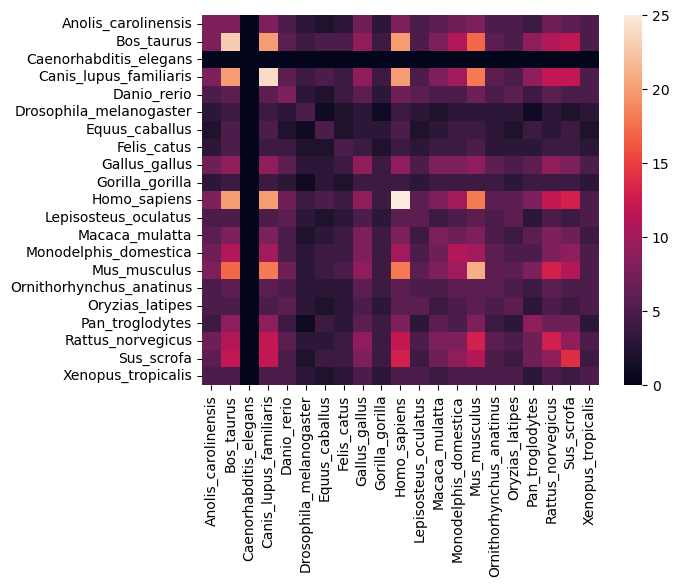

In [23]:
make_heatmap(xdf)
plt.savefig('results/plots/shared_categories.pdf', bbox_inches='tight')

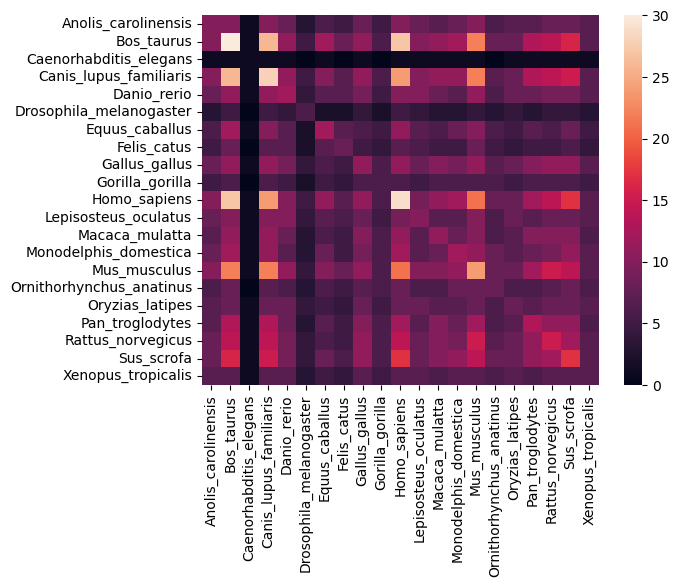

In [24]:
make_heatmap(xdf_agg)
plt.savefig('results/plots/shared_categories_agg.pdf', bbox_inches='tight')

Also plot with the species covered for each tissue

In [25]:
def species_per_category(df):
    m = len(df)
    n = len(all_species)
    
    X = np.zeros((m,n), dtype=np.uint8)
    for i in range(m):
        r = df.iloc[i]
        for j in range(n):
            X[i,j] = r[all_species[j]]
    return sns.heatmap(X, yticklabels=list(df['category']), xticklabels=all_species, cmap=['white', 'black'], cbar=False, vmin=0, vmax=1)            

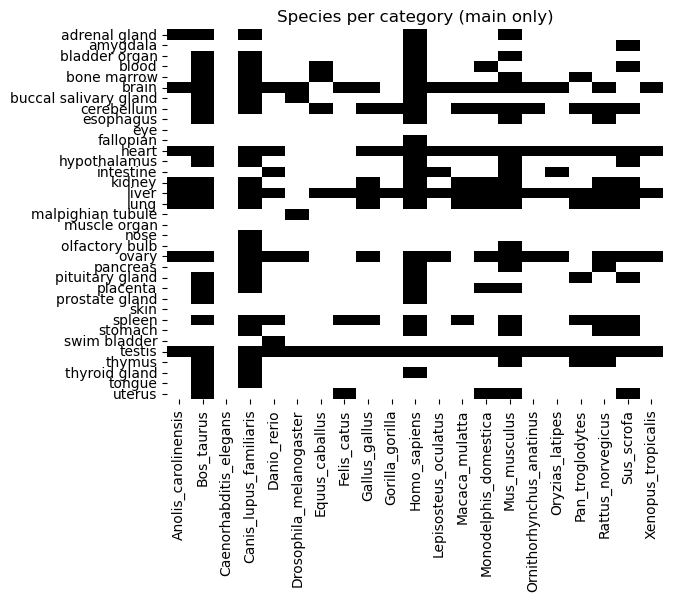

In [26]:
species_per_category(xdf)
plt.title('Species per category (main only)')
plt.savefig('results/plots/species_per_cat_main.pdf', bbox_inches='tight')

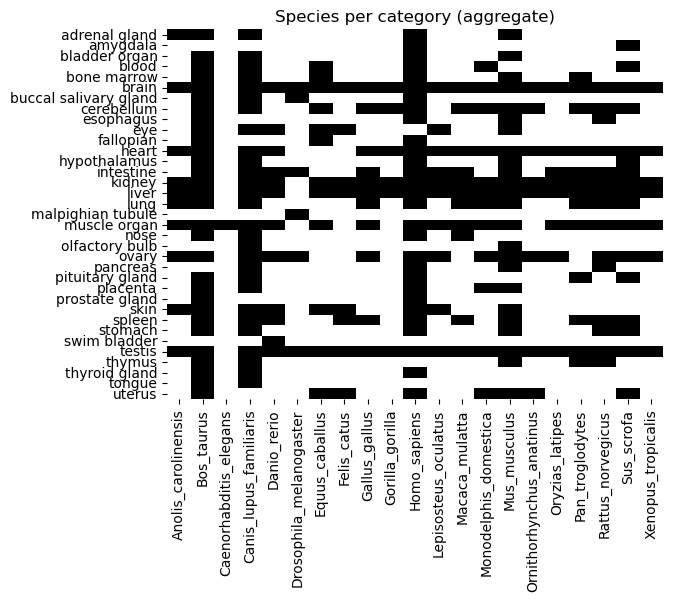

In [27]:
species_per_category(xdf_agg)
plt.title('Species per category (aggregate)')
plt.savefig('results/plots/species_per_cat_agg.pdf', bbox_inches='tight')

In [28]:
def species_per_category1(df, df1):
    m = len(df)
    n = len(all_species)
    
    X = np.zeros((m,n), dtype=np.uint8)
    for i in range(m):
        r = df.iloc[i]
        for j in range(n):
            X[i,j] = r[all_species[j]]
    return sns.heatmap(X, yticklabels=list(df['category']), xticklabels=all_species, cmap=['white', 'black'], cbar=False, vmin=0, vmax=1)            

---

## 6 - Translate Experiments into Categories

We also need to translate the experiments into the categories

In [30]:
# for the aggregate
uberon2cat = defaultdict(list)
for (cat, ts) in cat2uberon.items():
    for t in ts:
        uberon2cat[t].append(cat)

for (t, cats) in uberon2cat.items():
    uberon2cat[t] = '; '.join(cats)

uberon2cat = dict(uberon2cat)


# and for the main categories
uberon2maincat = {v: k for (k, v) in main_categories.items()}

In [31]:
res_df['category'] = res_df['anat_id'].apply(lambda x: uberon2cat.get(x, None))
res_df['main_category_only'] = res_df['anat_id'].apply(lambda x: uberon2maincat.get(x, None))

Let's filter out UBERON:0000068 (embryo stage) and UBERON:0007220 (late embryonic stage).

In [32]:
for (t, cats) in uberon2cat.items():
    uberon2cat[t] = list(map(lambda x: '_'.join(x.split(' ')), cats.split('; ')))

Print out the stages to curate which to include...

In [33]:
res_df[res_df.category.notna()].drop_duplicates('stage_id')[['stage_id', 'stage_name']].sort_values('stage_id').to_csv('./results/stages_to_curate.tsv', sep='\t', index=False)

In [35]:
# save the categorised table
res_df.to_csv('./results/experiments_with_tpm_categorised.tsv', sep='\t', index=False)

---

# 7 -- Transform RNASeq data into common format

Currently have two different formats for the plant and animal datasets, ideally we'd have these in a single common format.

In [45]:
# species that have data and are in PANTHER
dataset = {'animals': {'ANOCA','BOVIN','CAEEL','CANLF','CHICK','DANRE','DROME','FELCA','GORGO','HORSE','HUMAN','LEPOC','MACMU','MONDO','MOUSE','ORNAN','ORYLA','PANTR','PIG','RAT', 'XENTR'},
           'plants': {'AMBTC','ARATH','BRANA','CAPAN','CUCSA','HELAN','MAIZE','MANES','MARPO','MEDTR','ORYSJ','PHYPA','POPTR','SELML','SETIT','SOLLC','SOLTU','SOYBN','VITVI','WHEAT'}}

In [68]:
MIN_TPM_CUTOFF = 2.0

EXPR = './results/expr/'
!mkdir -p {EXPR}

ANIMAL_TPM_EXPR_FN = f'{EXPR}/animal_tpm_expr.h5'

### Animal Conversion

Convert full-matrices to a single table per-species and store using an HDF5 database.

In [64]:
use_cols = ['Library ID', 'Gene ID', 'Stage ID', 'Anatomical entity ID', 'TPM', 'Detection flag']
header_map = {'Experiment ID': 'exp_id',
              'Library ID': 'lib_id',
              'Gene ID': 'gene_id',
              'Anatomical entity ID': 'anat_id',
              'Anatomical entity name': 'anat_name',
              'Stage ID': 'stage_id',
              'Stage name': 'stage_name',
              'Sex': 'sex',
              'Strain': 'strain'}

stages_to_filter = {'UBERON:0000068',  # embryo stage
                    'UBERON:0007220'}  # late embyronic stage

def count_ngenes(fp):
    header = next(fp).rstrip().split(b'\t')
    assert header[1] == b'Library ID'
    lib_id = None
    c = 0
    for x in fp:
        x = x.rstrip().split(b'\t')
        if lib_id is None:
            lib_id = x[1]
        if lib_id == x[1]:
            c += 1
        else:
            break
    return c


for (sp, sp_code) in tqdm(sp_codes.items()):
    print(sp)
        
    fn = f'{sp}{ending}'
    fn1 = f'./data/bgee-{BGEE_VERSION}/{fn}'

    sp_genes_over_thresh = set()

    res = []
    with tarfile.open(fn1, 'r') as tar_fp:
        n_genes = None
        for member in tqdm(tar_fp.getnames()):
            print(member)
            if n_genes is None:
                x = gzip.GzipFile(fileobj=tar_fp.extractfile(member))
                n_genes = count_ngenes(x)
            
            x = gzip.GzipFile(fileobj=tar_fp.extractfile(member))
            # this is very specific to the downloaded files from bgee -- they are sorted by library id
            # so we can chunk by the number of genes per-genome
            for zdf in tqdm(pd.read_csv(x, sep='\t', low_memory=False, usecols=use_cols, chunksize=n_genes)):
                zdf = zdf.rename(columns=header_map)
                # check that there's no error and we really do have a single experiment 
                assert len(set(zdf.lib_id)) == 1
                assert len(set(zdf.stage_id)) == 1

                # extract experiment info
                (stage_id, anat_id, lib_id) = zdf.iloc[0][['stage_id', 'anat_id', 'lib_id']]
                
                if stage_id in stages_to_filter or (not anat_id.startswith('UBERON:')):
                    # quick skip
                    continue

                # set TPM = 0 for bgee's absent calls to avoid bias
                f = (zdf['Detection flag'] == 'absent')  # bgee has called it as -ve
                zdf.loc[f,'TPM'] = 0
                
                res.append(zdf[['gene_id', 'TPM']].set_index('gene_id'))
                res[-1].columns = pd.MultiIndex.from_tuples([(anat_id, lib_id)])


    df = pd.concat(res, axis=1)

    # filter so that we only keep genes where at least one tissue is expressed with >=2.0 TPM.
    genes_to_keep = list(df.index[(df >= MIN_TPM_CUTOFF).sum(axis=1) > 0])
    df.loc[genes_to_keep].to_hdf(ANIMAL_TPM_EXPR_FN, sp_code, complevel=9, complib='zlib')

  0%|          | 0/21 [00:00<?, ?it/s]

Anolis_carolinensis


  0%|          | 0/5 [00:00<?, ?it/s]

Anolis_carolinensis_RNA-Seq_read_counts_TPM_FPKM/Anolis_carolinensis_RNA-Seq_read_counts_TPM_FPKM_SRP045471.tsv.gz


0it [00:00, ?it/s]

Anolis_carolinensis_RNA-Seq_read_counts_TPM_FPKM/Anolis_carolinensis_RNA-Seq_read_counts_TPM_FPKM_SRP009813.tsv.gz


0it [00:00, ?it/s]

Anolis_carolinensis_RNA-Seq_read_counts_TPM_FPKM/Anolis_carolinensis_RNA-Seq_read_counts_TPM_FPKM_GSE41338.tsv.gz


0it [00:00, ?it/s]

Anolis_carolinensis_RNA-Seq_read_counts_TPM_FPKM/Anolis_carolinensis_RNA-Seq_read_counts_TPM_FPKM_SRP009831.tsv.gz


0it [00:00, ?it/s]

Anolis_carolinensis_RNA-Seq_read_counts_TPM_FPKM/Anolis_carolinensis_RNA-Seq_read_counts_TPM_FPKM_SRP103128.tsv.gz


0it [00:00, ?it/s]

Bos_taurus


  0%|          | 0/76 [00:00<?, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP116585.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP073720.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP092904.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_ERP016257.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP081047.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP063069.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP012475.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP070691.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_ERP006867.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP052314.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP094971.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP049415.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP041696.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_GSE43013.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP045380.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP072500.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP108615.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP051255.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP030211.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP089739.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP051257.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP024245.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP009677.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP059849.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP061367.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP030134.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP026485.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP065669.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_ERP002220.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP070110.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP042639.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP068029.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP126481.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP071940.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP033080.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_ERP006696.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP026487.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP033225.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP066644.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP045641.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP018740.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP043521.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP083944.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP045088.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP068653.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP095120.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP066556.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_ERP014610.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP032351.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP097223.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP014147.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP065213.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP074883.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP048734.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP039026.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP061388.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP021901.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP014561.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP012411.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_ERP023706.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_GSE41637.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP057141.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP067373.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP027560.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP071663.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP056112.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP068422.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP066548.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP075157.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP092050.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP074994.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP033585.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP111412.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP050127.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_SRP111067.tsv.gz


0it [00:00, ?it/s]

Bos_taurus_RNA-Seq_read_counts_TPM_FPKM/Bos_taurus_RNA-Seq_read_counts_TPM_FPKM_ERP005899.tsv.gz


0it [00:00, ?it/s]

Caenorhabditis_elegans


  0%|          | 0/6 [00:00<?, ?it/s]

Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM/Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM_SRP000401.tsv.gz


0it [00:00, ?it/s]

Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM/Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM_SRP021083.tsv.gz


0it [00:00, ?it/s]

Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM/Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM_GSE22410.tsv.gz


0it [00:00, ?it/s]

Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM/Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM_GSE41367.tsv.gz


0it [00:00, ?it/s]

Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM/Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM_SRP003492.tsv.gz


0it [00:00, ?it/s]

Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM/Caenorhabditis_elegans_RNA-Seq_read_counts_TPM_FPKM_GSE16552.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris


  0%|          | 0/25 [00:00<?, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_ERP001694.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_ERP015721.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_ERP003979.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP051588.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_ERP014610.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP016141.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP055477.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_DRP000415.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP077559.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_GSE43013.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_ERP000787.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP024250.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP121212.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP110851.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP061328.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP092128.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP007359.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP066652.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP068516.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_ERP019830.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP071663.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP114662.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP081080.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP009687.tsv.gz


0it [00:00, ?it/s]

Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM/Canis_lupus_familiaris_RNA-Seq_read_counts_TPM_FPKM_SRP012049.tsv.gz


0it [00:00, ?it/s]

Danio_rerio


  0%|          | 0/18 [00:00<?, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_SRP056356.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_SRP123447.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_GSE39703.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_SRP022612.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_SRP009426.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_GSE71681.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_GSE63133.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_GSE68666.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_SRP112616.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_SRP092128.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_GSE42846.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_SRP081209.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_GSE71755.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_GSE63191.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_SRP142618.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_SRP044781.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_ERP000447.tsv.gz


0it [00:00, ?it/s]

Danio_rerio_RNA-Seq_read_counts_TPM_FPKM/Danio_rerio_RNA-Seq_read_counts_TPM_FPKM_SRP055573.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster


  0%|          | 0/12 [00:00<?, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_SRP001696.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_GSE49587.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_SRP073726.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_SRP099257.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_SRP003905.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_GSE44612.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_GSE38998.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_SRP103757.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_SRP125768.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_SRP011074.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_SRP002072.tsv.gz


0it [00:00, ?it/s]

Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM/Drosophila_melanogaster_RNA-Seq_read_counts_TPM_FPKM_SRP009459.tsv.gz


0it [00:00, ?it/s]

Equus_caballus


  0%|          | 0/25 [00:00<?, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP064530.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_ERP006861.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP007347.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP082291.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_GSE43013.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP051087.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP076617.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP022567.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP049589.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP075700.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP091779.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP031504.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP113232.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP082454.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_ERP001525.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP106023.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_ERP005568.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP021940.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP073514.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_ERP001524.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP061328.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP082342.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP012972.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP082284.tsv.gz


0it [00:00, ?it/s]

Equus_caballus_RNA-Seq_read_counts_TPM_FPKM/Equus_caballus_RNA-Seq_read_counts_TPM_FPKM_SRP011379.tsv.gz


0it [00:00, ?it/s]

Felis_catus


  0%|          | 0/6 [00:00<?, ?it/s]

Felis_catus_RNA-Seq_read_counts_TPM_FPKM/Felis_catus_RNA-Seq_read_counts_TPM_FPKM_SRP042944.tsv.gz


0it [00:00, ?it/s]

Felis_catus_RNA-Seq_read_counts_TPM_FPKM/Felis_catus_RNA-Seq_read_counts_TPM_FPKM_GSE43013.tsv.gz


0it [00:00, ?it/s]

Felis_catus_RNA-Seq_read_counts_TPM_FPKM/Felis_catus_RNA-Seq_read_counts_TPM_FPKM_ERP014610.tsv.gz


0it [00:00, ?it/s]

Felis_catus_RNA-Seq_read_counts_TPM_FPKM/Felis_catus_RNA-Seq_read_counts_TPM_FPKM_SRP063937.tsv.gz


0it [00:00, ?it/s]

Felis_catus_RNA-Seq_read_counts_TPM_FPKM/Felis_catus_RNA-Seq_read_counts_TPM_FPKM_SRP115024.tsv.gz


0it [00:00, ?it/s]

Felis_catus_RNA-Seq_read_counts_TPM_FPKM/Felis_catus_RNA-Seq_read_counts_TPM_FPKM_SRP071078.tsv.gz


0it [00:00, ?it/s]

Gallus_gallus


  0%|          | 0/7 [00:00<?, ?it/s]

Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM/Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM_SRP092128.tsv.gz


0it [00:00, ?it/s]

Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM/Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM_GSE41637.tsv.gz


0it [00:00, ?it/s]

Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM/Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM_SRP057141.tsv.gz


0it [00:00, ?it/s]

Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM/Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM_GSE43520.tsv.gz


0it [00:00, ?it/s]

Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM/Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM_SRP097223.tsv.gz


0it [00:00, ?it/s]

Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM/Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM_GSE30352.tsv.gz


0it [00:00, ?it/s]

Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM/Gallus_gallus_RNA-Seq_read_counts_TPM_FPKM_GSE41338.tsv.gz


0it [00:00, ?it/s]

Gorilla_gorilla


  0%|          | 0/3 [00:00<?, ?it/s]

Gorilla_gorilla_RNA-Seq_read_counts_TPM_FPKM/Gorilla_gorilla_RNA-Seq_read_counts_TPM_FPKM_SRP021223.tsv.gz


0it [00:00, ?it/s]

Gorilla_gorilla_RNA-Seq_read_counts_TPM_FPKM/Gorilla_gorilla_RNA-Seq_read_counts_TPM_FPKM_GSE30352.tsv.gz


0it [00:00, ?it/s]

Gorilla_gorilla_RNA-Seq_read_counts_TPM_FPKM/Gorilla_gorilla_RNA-Seq_read_counts_TPM_FPKM_GSE43520.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens


  0%|          | 0/41 [00:00<?, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_E-MTAB-2449.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_ERP000787.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_ERP003613.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_ERP006650.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_ERP006696.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_ERP014610.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_GSE30352.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_GSE30611.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_GSE43520.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_GSE57344.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_GSE58387.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_GSE58608.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_GSE62098.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_GSE64283.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP001558.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP003276.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP007359.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP007481.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP008743.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP012682.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP013825.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP019762.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP028336.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP029262.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP029592.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP034732.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP034929.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP051844.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP058036.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP058740.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP065273.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP066912.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP073607.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP092128.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP101726.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP101737.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP105769.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP125959.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP127360.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP127986.tsv.gz


0it [00:00, ?it/s]

Homo_sapiens_RNA-Seq_read_counts_TPM_FPKM_SRP163252.tsv.gz


0it [00:00, ?it/s]

Lepisosteus_oculatus


  0%|          | 0/2 [00:00<?, ?it/s]

Lepisosteus_oculatus_RNA-Seq_read_counts_TPM_FPKM/Lepisosteus_oculatus_RNA-Seq_read_counts_TPM_FPKM_SRP042013.tsv.gz


0it [00:00, ?it/s]

Lepisosteus_oculatus_RNA-Seq_read_counts_TPM_FPKM/Lepisosteus_oculatus_RNA-Seq_read_counts_TPM_FPKM_SRP044782.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta


  0%|          | 0/22 [00:00<?, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP017517.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_ERP006696.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP009818.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP003276.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP028336.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP058740.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP001558.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP034929.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_ERP000787.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_GSE30352.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_ERP002376.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_ERP014610.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP008743.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_GSE43520.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP065273.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP009336.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_DRP000895.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP019755.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP021223.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP057141.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_GSE41637.tsv.gz


0it [00:00, ?it/s]

Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM/Macaca_mulatta_RNA-Seq_read_counts_TPM_FPKM_SRP007359.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica


  0%|          | 0/16 [00:00<?, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP057141.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP066905.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP007481.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_ERP000787.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP121212.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP019501.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP071663.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP011985.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP098705.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP008743.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_GSE43520.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP036951.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_GSE30352.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP013391.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_ERP014610.tsv.gz


0it [00:00, ?it/s]

Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM/Monodelphis_domestica_RNA-Seq_read_counts_TPM_FPKM_SRP061644.tsv.gz


0it [00:00, ?it/s]

Mus_musculus


  0%|          | 0/36 [00:00<?, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_GSE43520.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP008743.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP045673.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP086707.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP010955.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP020526.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP114436.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_GSE30352.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP162729.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP048535.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP058709.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_GSE30617.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP092128.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP007359.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP135698.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP057141.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_GSE41637.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP104670.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP007655.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP074330.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP013825.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP053433.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_ERP012910.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP092799.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP061644.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP070644.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_GSE43013.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_GSE43721.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP013027.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_ERP000787.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_ERP104395.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_GSE41338.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP022612.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP058740.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP028336.tsv.gz


0it [00:00, ?it/s]

Mus_musculus_RNA-Seq_read_counts_TPM_FPKM/Mus_musculus_RNA-Seq_read_counts_TPM_FPKM_SRP045471.tsv.gz


0it [00:00, ?it/s]

Ornithorhynchus_anatinus


  0%|          | 0/4 [00:00<?, ?it/s]

Ornithorhynchus_anatinus_RNA-Seq_read_counts_TPM_FPKM/Ornithorhynchus_anatinus_RNA-Seq_read_counts_TPM_FPKM_SRP042024.tsv.gz


0it [00:00, ?it/s]

Ornithorhynchus_anatinus_RNA-Seq_read_counts_TPM_FPKM/Ornithorhynchus_anatinus_RNA-Seq_read_counts_TPM_FPKM_GSE43520.tsv.gz


0it [00:00, ?it/s]

Ornithorhynchus_anatinus_RNA-Seq_read_counts_TPM_FPKM/Ornithorhynchus_anatinus_RNA-Seq_read_counts_TPM_FPKM_SRP011081.tsv.gz


0it [00:00, ?it/s]

Ornithorhynchus_anatinus_RNA-Seq_read_counts_TPM_FPKM/Ornithorhynchus_anatinus_RNA-Seq_read_counts_TPM_FPKM_GSE30352.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes


  0%|          | 0/15 [00:00<?, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_SRP049254.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_SRP000304.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_SRP008998.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_SRP021892.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_DRP000571.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_SRP066987.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_DRP003809.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_SRP004363.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_SRP123447.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_SRP041650.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_SRP116580.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_DRP001158.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_ERP010733.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_ERP010463.tsv.gz


0it [00:00, ?it/s]

Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM/Oryzias_latipes_RNA-Seq_read_counts_TPM_FPKM_SRP044784.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes


  0%|          | 0/18 [00:00<?, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP092096.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_DRP000894.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP003276.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP034929.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP001558.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP058740.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP028336.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP044228.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_ERP002376.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_GSE30352.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP008743.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP065273.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP019762.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP051959.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP021223.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP019755.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_SRP009336.tsv.gz


0it [00:00, ?it/s]

Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM/Pan_troglodytes_RNA-Seq_read_counts_TPM_FPKM_DRP003657.tsv.gz


0it [00:00, ?it/s]

Rattus_norvegicus


  0%|          | 0/10 [00:00<?, ?it/s]

Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM/Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM_SRP030211.tsv.gz


0it [00:00, ?it/s]

Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM/Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM_GSE43013.tsv.gz


0it [00:00, ?it/s]

Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM/Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM_ERP104395.tsv.gz


0it [00:00, ?it/s]

Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM/Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM_ERP000787.tsv.gz


0it [00:00, ?it/s]

Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM/Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM_SRP029760.tsv.gz


0it [00:00, ?it/s]

Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM/Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM_ERP001694.tsv.gz


0it [00:00, ?it/s]

Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM/Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM_ERP014610.tsv.gz


0it [00:00, ?it/s]

Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM/Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM_SRP106852.tsv.gz


0it [00:00, ?it/s]

Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM/Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM_SRP007359.tsv.gz


0it [00:00, ?it/s]

Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM/Rattus_norvegicus_RNA-Seq_read_counts_TPM_FPKM_GSE41637.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa


  0%|          | 0/35 [00:00<?, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP064513.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP066092.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP108727.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_ERP013735.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP062160.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_ERP001954.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP058576.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP061644.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_ERP105435.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_GSE43013.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_DRP003299.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_ERP010826.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP082487.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP117198.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP070951.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP064327.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP018740.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_ERP001694.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_ERP002055.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_GSE43892.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP112393.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP027378.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP066398.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP069860.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_ERP014610.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP062860.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP095747.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_ERP009821.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP105069.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_ERP105028.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP060608.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP066797.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP032451.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_SRP067000.tsv.gz


0it [00:00, ?it/s]

Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM/Sus_scrofa_RNA-Seq_read_counts_TPM_FPKM_E-MTAB-5895.tsv.gz


0it [00:00, ?it/s]

Xenopus_tropicalis


  0%|          | 0/5 [00:00<?, ?it/s]

Xenopus_tropicalis_RNA-Seq_read_counts_TPM_FPKM/Xenopus_tropicalis_RNA-Seq_read_counts_TPM_FPKM_GSE43652.tsv.gz


0it [00:00, ?it/s]

Xenopus_tropicalis_RNA-Seq_read_counts_TPM_FPKM/Xenopus_tropicalis_RNA-Seq_read_counts_TPM_FPKM_GSE43520.tsv.gz


0it [00:00, ?it/s]

Xenopus_tropicalis_RNA-Seq_read_counts_TPM_FPKM/Xenopus_tropicalis_RNA-Seq_read_counts_TPM_FPKM_SRP053406.tsv.gz


0it [00:00, ?it/s]

Xenopus_tropicalis_RNA-Seq_read_counts_TPM_FPKM/Xenopus_tropicalis_RNA-Seq_read_counts_TPM_FPKM_GSE37452.tsv.gz


0it [00:00, ?it/s]

Xenopus_tropicalis_RNA-Seq_read_counts_TPM_FPKM/Xenopus_tropicalis_RNA-Seq_read_counts_TPM_FPKM_GSE41338.tsv.gz


0it [00:00, ?it/s]

### Plant Conversion

In [69]:
PLANT_GENERAL_TPM_EXPR_FN = f'{EXPR}/plant_general_tpm_expr.h5'
PLANT_SPECIFIC_TPM_EXPR_FN = f'{EXPR}/plant_specific_tpm_expr.h5'

In [ ]:
raw_path = 'data/plant_expr/tpm'

sra_annots = pd.read_csv(f'{raw_path}/SRA_annot_all.tsv', sep='\t')
general_names = sra_annots.set_index('SRA_exp')['Gname'].to_dict()
specific_names = sra_annots.set_index('SRA_exp')['Sname'].to_dict()

with open(f'{raw_path}/to_exclude.txt', 'rt') as fp:
    to_exclude = set(map(lambda x: x.rstrip(), fp))
    to_exclude.add('-')


for sp_code in tqdm(dataset['plants']):
    print(sp_code)
    raw_fn = f'{raw_path}/{sp_code}.newMatrix.txt.gz'
    df = pd.read_csv(raw_fn, sep='\t').rename(columns={'genes': 'gene_id'}).set_index('gene_id')
    
    # filter to genes with at least one sample >= 2.0 TPM
    sp_genes_over_thresh = set(df.index[(df >= MIN_TPM_CUTOFF).sum(axis=1) > 0])
    df = df.loc[df.index.isin(sp_genes_over_thresh)]

    # filter out tissues that we don't want
    to_delete = []
    for k in tqdm(df.keys()):
        if general_names[k] in to_exclude:
            to_delete.append(k)
    df = df.drop(to_delete, axis=1)

    # now map to mi
    gen_idx = []
    spc_idx = []
    for k in tqdm(df.keys()):
        gen_idx.append((general_names[k], k))
        spc_idx.append((specific_names[k], k))

    # everything has both general / specific naming so we can just reset the column index
    df.columns = pd.MultiIndex.from_tuples(gen_idx)
    df.to_hdf(PLANT_GENERAL_TPM_EXPR_FN, sp_code, complevel=9, complib='zlib')
    
    df.columns = pd.MultiIndex.from_tuples(spc_idx)
    df.to_hdf(PLANT_SPECIFIC_TPM_EXPR_FN, sp_code, complevel=9, complib='zlib')

  0%|          | 0/20 [00:00<?, ?it/s]

AMBTC


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

SOYBN


  0%|          | 0/3303 [00:00<?, ?it/s]

  0%|          | 0/2674 [00:00<?, ?it/s]

ORYSJ


  0%|          | 0/7995 [00:00<?, ?it/s]

  0%|          | 0/6062 [00:00<?, ?it/s]

ARATH


  0%|          | 0/22925 [00:00<?, ?it/s]

  0%|          | 0/11722 [00:00<?, ?it/s]

MEDTR


  0%|          | 0/1610 [00:00<?, ?it/s]

  0%|          | 0/1385 [00:00<?, ?it/s]

SELML


  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

HELAN


  0%|          | 0/931 [00:00<?, ?it/s]

  0%|          | 0/743 [00:00<?, ?it/s]

CAPAN


  0%|          | 0/423 [00:00<?, ?it/s]

  0%|          | 0/385 [00:00<?, ?it/s]

VITVI


  0%|          | 0/3032 [00:00<?, ?it/s]

  0%|          | 0/2672 [00:00<?, ?it/s]

POPTR


  0%|          | 0/3865 [00:00<?, ?it/s]

  0%|          | 0/2804 [00:00<?, ?it/s]

CUCSA


  0%|          | 0/902 [00:00<?, ?it/s]

  0%|          | 0/873 [00:00<?, ?it/s]

MANES


  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/446 [00:00<?, ?it/s]

SOLTU


  0%|          | 0/1437 [00:00<?, ?it/s]

  0%|          | 0/1246 [00:00<?, ?it/s]

---

## 8 - Categorise and filter animal tissues

The plant data is already categorised and filtered. We still need to transform the UBERON terms to the curated categories for the animal dataset.

Embryo developmental stages have already been filtered out at the previous step.

In [72]:
def map_to_category(df, catmap):
    def check_nonempty():
        return len(set(map(lambda x: x[0], df.columns)) & set(catmap.keys())) > 0

    def gen():
        terms = set(map(lambda x: x[0], df.columns))
        for k in filter(lambda k: k in terms, catmap):
            cats = [catmap[k]] if isinstance(catmap[k], str) else catmap[k]
            for cat in cats:
                zdf = df.loc[:,k].copy()
                zdf.columns = pd.MultiIndex.from_tuples(map(lambda x: (cat, x), zdf.columns))
                yield zdf
    
    if check_nonempty():
        return pd.concat(gen(), axis=1)


def map_db_to_category(db_fn, out_fn, catmap):
    in_db = pd.HDFStore(db_fn, mode='r')
    if not os.path.isfile(out_fn):
        for n in tqdm(in_db.root):
            sp = n._v_name
            print(sp)
            expr_df = pd.read_hdf(in_db, sp)
            expr_df1 = map_to_category(expr_df, catmap)
            if expr_df1 is not None:
                expr_df1.to_hdf(out_fn, sp, complevel=9, complib='zlib')

In [74]:
map_db_to_category(db_fn=ANIMAL_TPM_EXPR_FN,
                   out_fn=f'{EXPR}/animal_maincat_tpm_expr.h5',
                   catmap=uberon2maincat)

map_db_to_category(db_fn=ANIMAL_TPM_EXPR_FN,
                   out_fn=f'{EXPR}/animal_categorised_tpm_expr.h5',
                   catmap=uberon2cat)